In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import glob
import argparse

In [2]:

FOLDER_PATH = "results/Llama-3-8B-Instruct-Gradient-1048k/"
MODEL_NAME = "Llama-3-8B-Instruct-Gradient-1048k"
PRETRAINED_LEN = 32000


model_name = Llama-3-8B-Instruct-Gradient-1048k
     Document Depth  Context Length     Score
0               0.0           80000  0.833333
1              11.0           80000  0.833333
2              22.0           80000  0.833333
3              33.0           80000  0.833333
4              44.0           80000  0.833333
..              ...             ...       ...
105            56.0          328205  0.916667
106            67.0          328205  0.916667
107            78.0          328205  0.916667
108            89.0          328205  0.916667
109           100.0          328205  0.916667

[110 rows x 3 columns]
   Document Depth  Context Length     Score
0             0.0           80000  0.833333
1            11.0           80000  0.833333
2            22.0           80000  0.833333
3            33.0           80000  0.833333
4            44.0           80000  0.833333
Overall score 0.906
saving at img/Llama-3-8B-Instruct-Gradient-1048k.png


FileNotFoundError: [Errno 2] No such file or directory: '/duo-attention/img/Llama-3-8B-Instruct-Gradient-1048k.png'

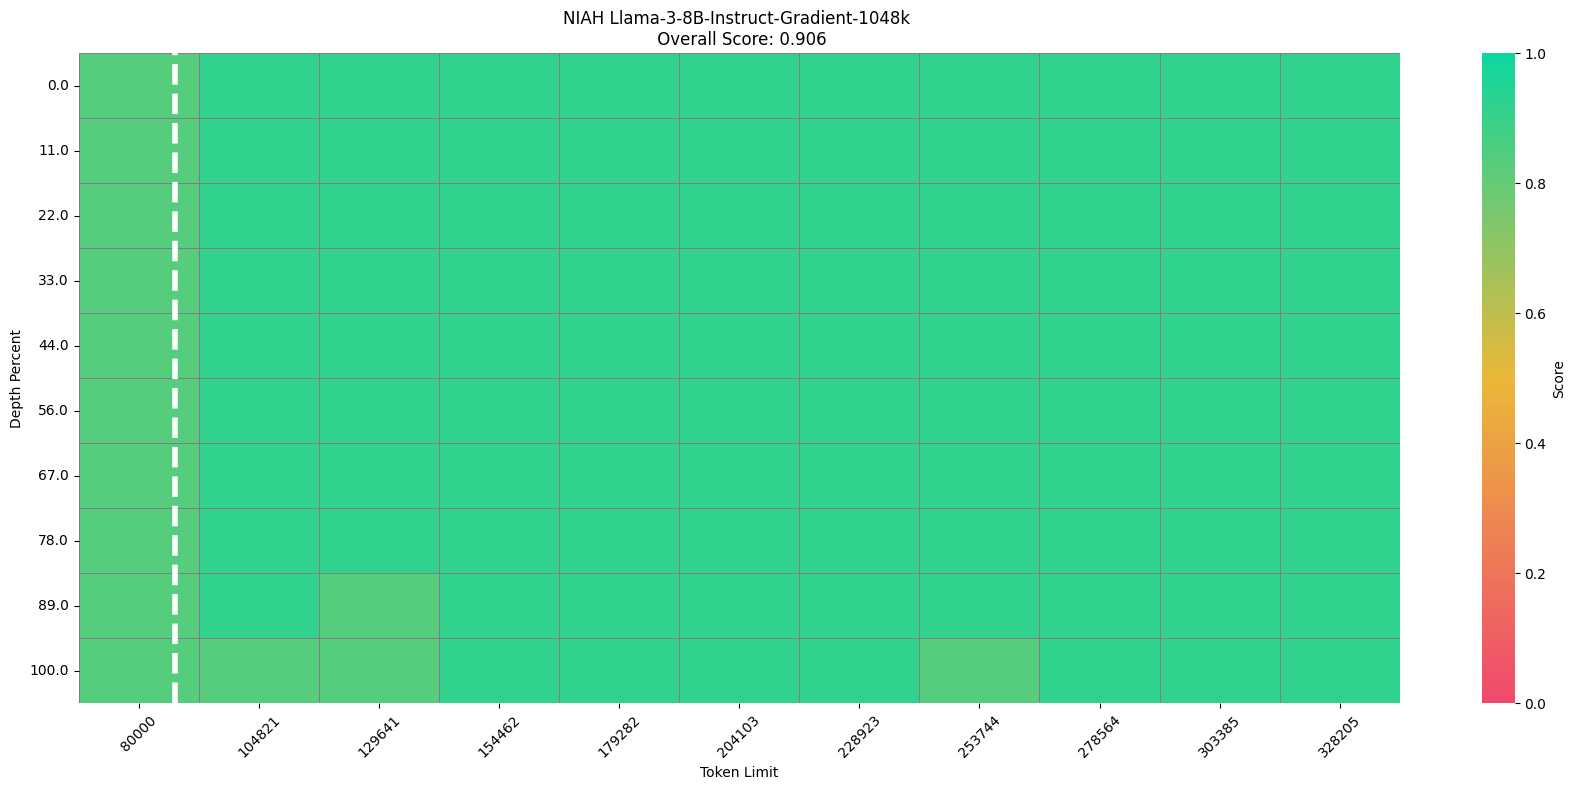

In [3]:
folder_path = FOLDER_PATH
if "/" in folder_path:
    model_name = folder_path.split("/")[-2]
else:
    model_name = MODEL_NAME
print("model_name = %s" % model_name)

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}*.json")
# import ipdb; ipdb.set_trace()

# List to hold the data
data = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, "r") as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        # score = json_data.get("score", None)
        model_response = json_data.get("model_response", None).lower()
        needle = json_data.get("needle", None).lower()
        expected_answer = (
            "eat a sandwich and sit in Dolores Park on a sunny day.".lower().split()
        )
        score = len(
            set(model_response.split()).intersection(set(expected_answer))
        ) / len(expected_answer)
        # Appending to the list
        data.append(
            {
                "Document Depth": document_depth,
                "Context Length": context_length,
                "Score": score,
            }
        )

# Creating a DataFrame
df = pd.DataFrame(data)
print(df)
locations = list(df["Context Length"].unique())
locations.sort()
for li, l in enumerate(locations):
    if l > PRETRAINED_LEN:
        break
pretrained_len = li

print(df.head())
print("Overall score %.3f" % df["Score"].mean())

pivot_table = pd.pivot_table(
    df, values="Score", index=["Document Depth", "Context Length"], aggfunc="mean"
).reset_index()  # This will aggregate
pivot_table = pivot_table.pivot(
    index="Document Depth", columns="Context Length", values="Score"
)  # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"]
)

# Create the heatmap with better aesthetics
f = plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
heatmap = sns.heatmap(
    pivot_table,
    vmin=0,
    vmax=1,
    cmap=cmap,
    cbar_kws={"label": "Score"},
    linewidths=0.5,  # Adjust the thickness of the grid lines here
    linecolor="grey",  # Set the color of the grid lines
    linestyle="--",
)

# More aesthetics
model_name_ = MODEL_NAME
plt.title(
    f'NIAH {model_name_} \n Overall Score: {df["Score"].mean():.3f}'
)  # Adds a title
plt.xlabel("Token Limit")  # X-axis label
plt.ylabel("Depth Percent")  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Add a vertical line at the desired column index
plt.axvline(x=pretrained_len + 0.8, color="white", linestyle="--", linewidth=4)

save_path = "img/%s.png" % model_name
print("saving at %s" % save_path)
plt.savefig(save_path, dpi=150)